In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import textwrap

def plot_metric_grid(dfs_dict, methods, metric):
    """
    Plots a specific metric for multiple DataFrames in a grid.
    """
    n = len(dfs_dict)
    cols = 2
    rows = math.ceil(n / cols)
    
    fig, ax = plt.subplots(rows, cols, figsize=(12, 5 * rows), sharex=False, sharey="row")
    # Ensure ax is always iterable even if n=1
    if n == 1: ax = np.array([ax])
    ax = ax.flatten()
    
    # Remove empty subplots
    for j in range(n, len(ax)):
        fig.delaxes(ax[j])

    for i, (name, df) in enumerate(dfs_dict.items()):
        current_ax = ax[i]
        
        for method in methods:
            cond = (df["T"] == 300)
            subset = df[(df["Estimator"] == method) & cond]
            
            groups = subset.groupby("m")
            
            means = groups[metric].mean()
            q1 = groups[metric].quantile(0.025)
            q3 = groups[metric].quantile(0.975)
            
            current_ax.errorbar(
                means.index, means, 
                yerr=[np.abs(means - q1), np.abs(q3 - means)], 
                label=method,
                capsize=5, marker='o', linestyle='-'
            )
            
            # std = groups["Std"].max()
            # current_ax.plot(means.index, std, color="k", linestyle="--")
        
        current_ax.set_title(f"Setup: {name}")
        current_ax.set_xlabel("Matrix Size (m)")
        current_ax.set_ylabel(metric)
        current_ax.legend(loc='upper left')
        current_ax.grid(True)

    plt.suptitle(f"{metric} vs Matrix Size\n(Data Size = 300)")
    plt.tight_layout()
    return fig, ax

def plot_instability(dfs_dict, methods):
    """
    Plots a single grouped bar chart comparing instability across multiple DataFrames
    using a softer color palette.
    """
    # 1. Setup Data
    plot_data = {}
    for name, df in dfs_dict.items():
        percentages = []
        for method in methods:
            subset = df[df["Estimator"] == method]
            if len(subset) > 0:
                unstable_count = (subset["Spectral Norm"] > 1.0).sum()
                total_count = len(subset)
                pct = (unstable_count / total_count) * 100
            else:
                pct = 0
            percentages.append(pct)
        plot_data[name] = percentages

    # 2. Setup Plot Dimensions and Colors
    fig, ax = plt.subplots(figsize=(6, 4))
    
    x = np.arange(len(methods))
    n_dfs = len(dfs_dict)
    width = 0.8 / n_dfs 
    
    # --- COLOR SELECTION ---
    # Use 'Set2' colormap for softer, muted tones. 
    # It has 8 distinct colors. If you have >8 DFs, we switch to a larger map.
    cmap = plt.get_cmap('Set2')
    if n_dfs <= 8:
        colors = cmap.colors[:n_dfs]
    else:
        # Fallback for many datasets
        cmap = plt.get_cmap('tab20c')
        colors = [cmap(i) for i in np.linspace(0, 1, n_dfs)]
        
    # 3. Plot Bars
    start_offset = - ((n_dfs * width) / 2) + (width / 2)
    
    for i, (name, values) in enumerate(plot_data.items()):
        offset = start_offset + (i * width)
        rects = ax.bar(
            x + offset, 
            values, 
            width, 
            label=name, 
            # color=colors[i],     # Apply the selected soft color
            edgecolor='#555555', # Dark grey edge instead of harsh black
            linewidth=0.7,
            alpha=0.95           # High alpha since colors are already muted
        )

    # 4. Formatting
    wrapped_labels = ["\n".join(textwrap.wrap(m, width=9)) for m in methods]
    
    ax.set_ylabel('Percentage Unstable (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(wrapped_labels, rotation=0)
    # ax.set_ylim(0, 100)
    
    # Place legend outside if it crowds the plot, otherwise inside is fine
    ax.legend(title="Datasets", loc='best', frameon=True, fancybox=True, framealpha=0.8)
    
    # Softer grid lines
    ax.grid(axis='y', linestyle=':', color='grey', alpha=0.6)

    plt.tight_layout()
    return fig, ax

In [2]:
dfs = {
    "VAR flawed": pd.read_csv('../results/experiment_results_VAR_flawed.csv'), 
    "VAR": pd.read_csv('../results/experiment_results_VAR.csv'), 
    "MAR": pd.read_csv('../results/experiment_results_MAR.csv'),
    "MAR symmetric": pd.read_csv('../results/experiment_results_MAR_symmetric.csv')
}

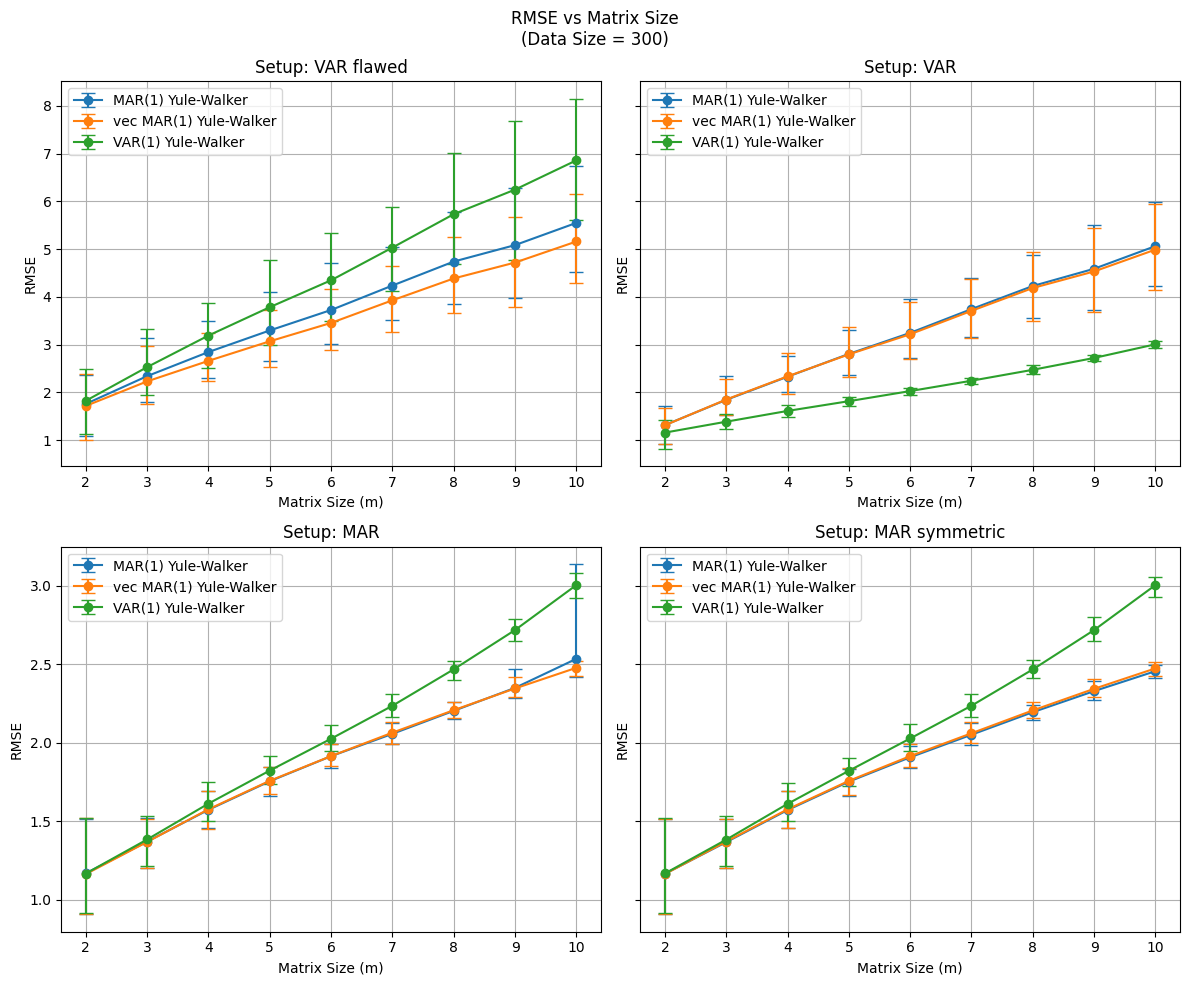

In [3]:
methods = ["MAR(1) Yule-Walker", "vec MAR(1) Yule-Walker", "VAR(1) Yule-Walker"]
fig, ax = plot_metric_grid(dfs, methods, metric="RMSE")
fig.savefig('yw.svg')

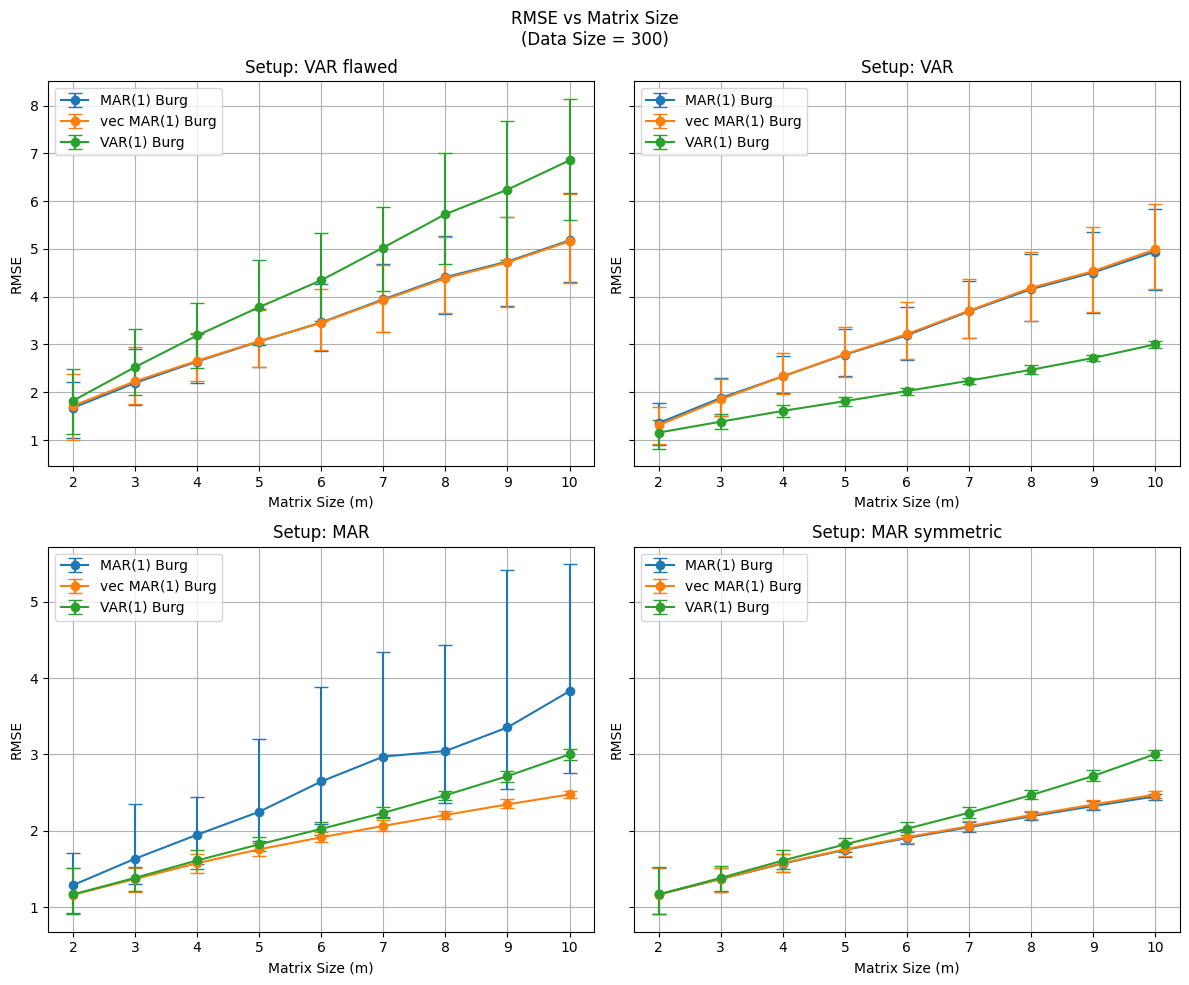

In [4]:
methods = ["MAR(1) Burg", "vec MAR(1) Burg", "VAR(1) Burg"]
fig, ax = plot_metric_grid(dfs, methods, metric="RMSE")
fig.savefig('burg.svg')

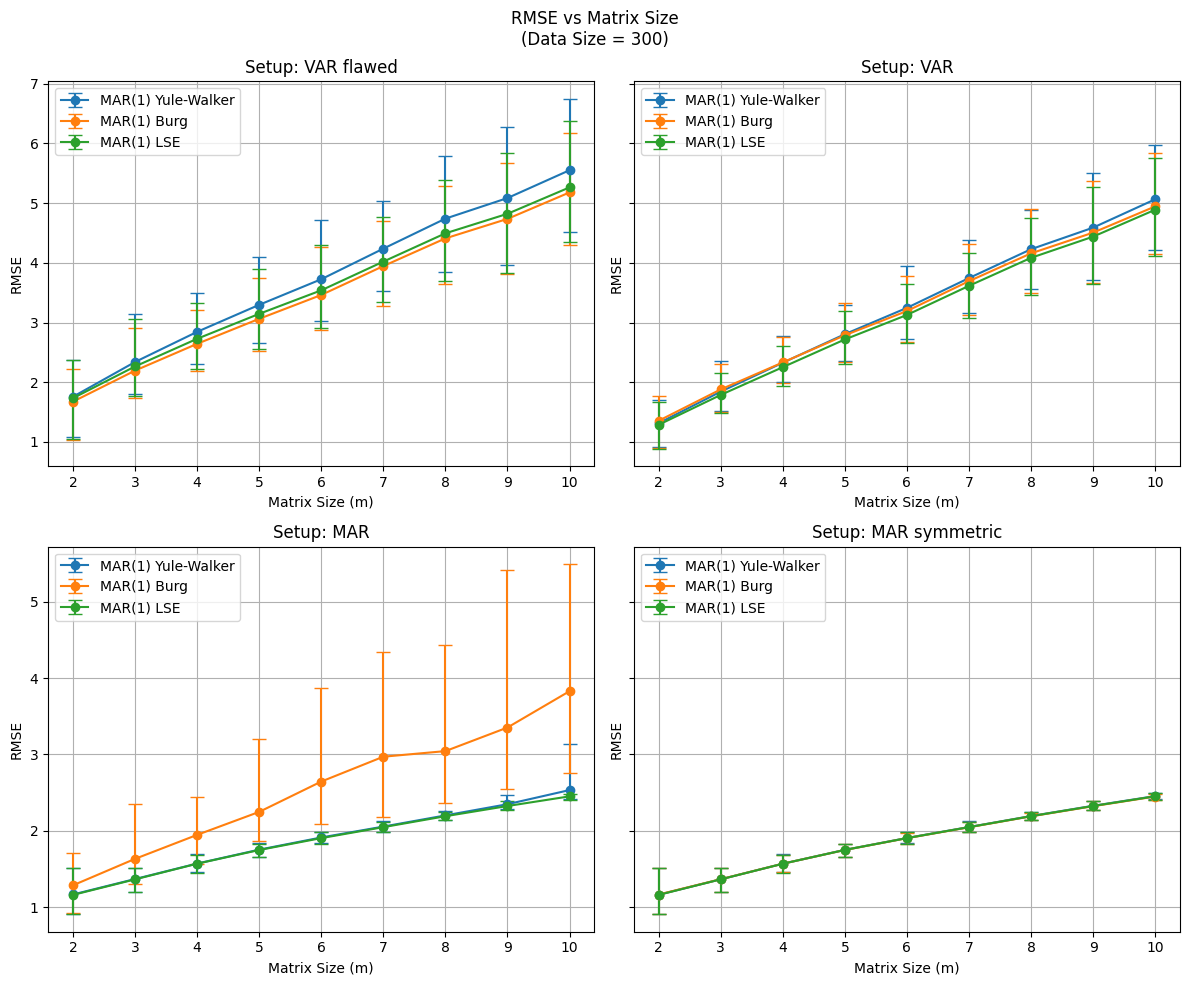

In [5]:
methods = ["MAR(1) Yule-Walker", "MAR(1) Burg", "MAR(1) LSE"]
fig, ax = plot_metric_grid(dfs, methods, metric="RMSE")
fig.savefig('all.svg')

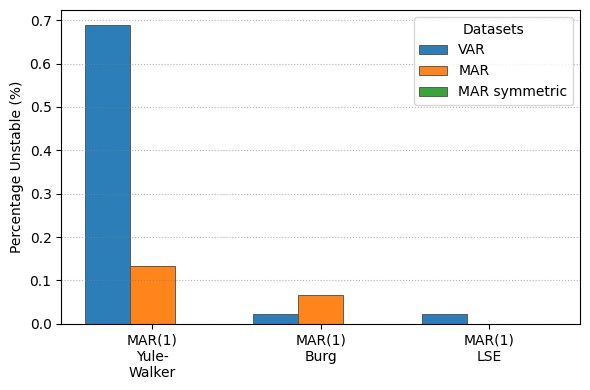

In [6]:
dfs_cut = {"VAR": dfs["VAR"], "MAR": dfs["MAR"], "MAR symmetric": dfs["MAR symmetric"]}
fig, ax = plot_instability(dfs_cut, ["MAR(1) Yule-Walker", "MAR(1) Burg", "MAR(1) LSE"])
fig.savefig('instability.svg')